##  Домашнее задание № 6: Пироги с глазами!

**Google опрос для отправки**: https://forms.gle/WWrHkAUpV5CwBkVi8


**Soft deadline** : 22.06.2022T23:59:00+0300

**Hard deadline:** 29.06.2022T23:59:00+0300

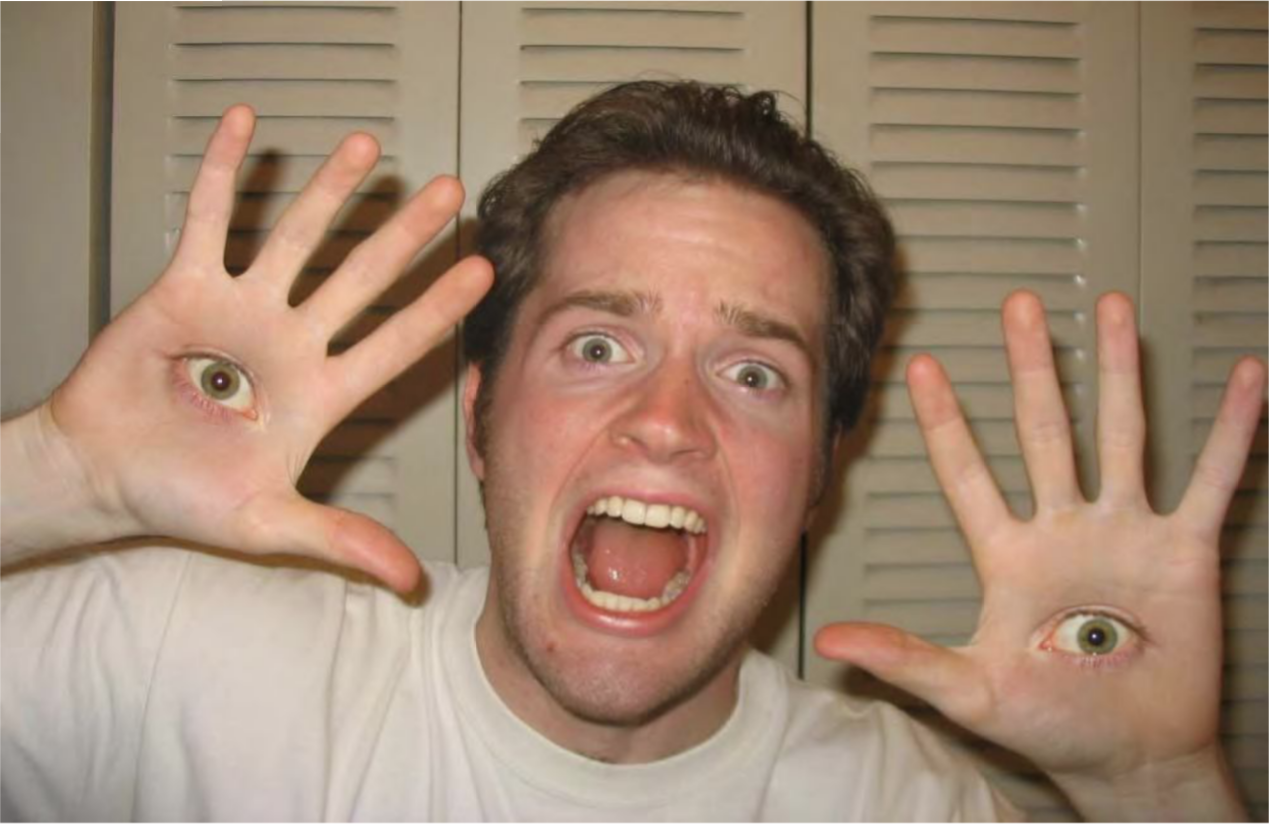

### Пирамида лапласа

**(15 баллов)** Используя прием сшивки изображений с помощью пирамиды Лапласа, повторите прием с вашими глазами и вашими руками (или сделайте что-то похожее по смыслу)

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

In [ ]:
def gaussian_pyramid(img, n_levels):
    pyramid = [img]
    for _ in range(n_levels):
        pyramid.append(cv2.pyrDown(pyramid[-1]))
    return pyramid


def laplace_pyramid(gp):
    n_levels = len(gp) - 1
    pyramid = [gp[-1]]
    for i in range(n_levels, 0, -1):
        upsample_img = cv2.pyrUp(gp[i], dstsize=gp[i - 1].shape[:2][::-1])
        pyramid.append(
            cv2.subtract(gp[i - 1], upsample_img)
        )
    return pyramid


def combined_laplacian(laplacian1, laplacian2, gp_mask):
    result = []
    for mask, lp1, lp2, in zip(gp_mask, laplacian1[::-1], laplacian2[::-1]):
        tmp = lp1 * (1 - mask) + lp2 * mask
        result.append(tmp)
    return result[::-1]


def reconstruct_from_pyramids(pyramids):
    result = pyramids[0]
    for p in pyramids[1:]:
        dstsize = p.shape[:2][::-1]
        up_image = cv2.pyrUp(result, dstsize=dstsize)
        result = cv2.add(p, up_image)
    return result

In [ ]:
img = cv2.imread('/content/img_hw.jpg')
## LEFT HAND and EYE
left_eye = img[350: 410, 500: 600]
left_eye = cv2.resize(left_eye, None, fx=1.5, fy=1.5)  # (90, 150, 3)

left_mask = np.zeros(left_eye.shape)
left_mask = cv2.ellipse(left_mask,  # img
                        (65, 45),  # center
                        (50, 35),  # axes
                        0,  # angle
                        0,  # start angle
                        360,  # start angle
                        color=(1, 1, 1),
                        thickness=-1)  # foreground
left_hand = img[810: 900, 310: 460]

##RIGHT HAND and EYE

right_eye = img[340: 400, 610: 700]
right_eye = cv2.resize(right_eye, None, fx=1.5, fy=1.5)  # (90, 135, 3)
right_mask = np.zeros(right_eye.shape)
right_mask = cv2.ellipse(right_mask,  # img
                        (75, 50),  # center
                        (52, 37),  # axes
                        0,  # angle
                        0,  # start angle
                        360,  # start angle
                        color=(1, 1, 1),
                        thickness=-1)  # foreground
right_hand = img[480: 570, 925: 1060]


In [ ]:
n_levels = 3
gp_mask = gaussian_pyramid(left_mask, n_levels)

eye_gauss_pyramids = gaussian_pyramid(left_eye, n_levels)
eye_laplace_pyramids = laplace_pyramid(eye_gauss_pyramids)

hand_gauss_pyramids = gaussian_pyramid(left_hand, n_levels)
hand_laplace_pyramids = laplace_pyramid(hand_gauss_pyramids)

comb_laplacian = combined_laplacian(hand_laplace_pyramids, eye_laplace_pyramids, gp_mask)

left_eye = reconstruct_from_pyramids(comb_laplacian).astype('uint8')

gp_mask = gaussian_pyramid(right_mask, n_levels)

eye_gauss_pyramids = gaussian_pyramid(right_eye, n_levels)
eye_laplace_pyramids = laplace_pyramid(eye_gauss_pyramids)

hand_gauss_pyramids = gaussian_pyramid(right_hand, n_levels)
hand_laplace_pyramids = laplace_pyramid(hand_gauss_pyramids)

comb_laplacian = combined_laplacian(hand_laplace_pyramids, eye_laplace_pyramids, gp_mask)

right_eye = reconstruct_from_pyramids(comb_laplacian).astype('uint8')

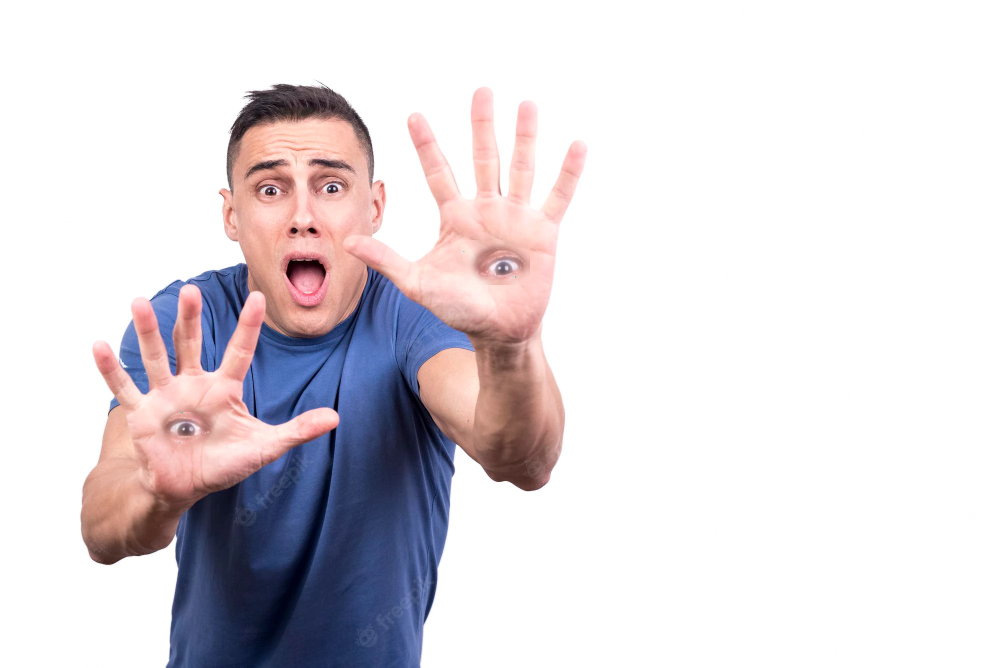

In [ ]:
result = img.copy()
result[810: 900, 310: 460] = left_eye
result[480: 570, 925: 1060] = right_eye
result_0 = cv2.resize(result , None, fx=.5, fy=.5)  # (90, 150, 3)
cv2_imshow(result_0)

### Deep Image Prior
**(15 баллов)** Используя подход [Deep Image Prior](https://github.com/DmitryUlyanov/deep-image-prior) и его способность восстанавливать изображения, повторите прием с вашими глазами и вашими руками (или сделайте что-то похожее по смыслу)

In [ ]:
!git clone https://github.com/DmitryUlyanov/deep-image-prior.git deep_image_prior

In [ ]:
import torch
import torch.optim

from deep_image_prior.models.resnet import ResNet
from deep_image_prior.models.unet import UNet
from deep_image_prior.models.skip import skip
from deep_image_prior.utils.inpainting_utils import *

In [ ]:
def adopt_image_size(img: np.ndarray, d: int = 32):
    '''Make dimensions divisible by `d`'''
    new_size = (img.shape[1] - img.shape[1] % d,
                img.shape[0] - img.shape[0] % d)
    return cv2.resize(img, new_size)

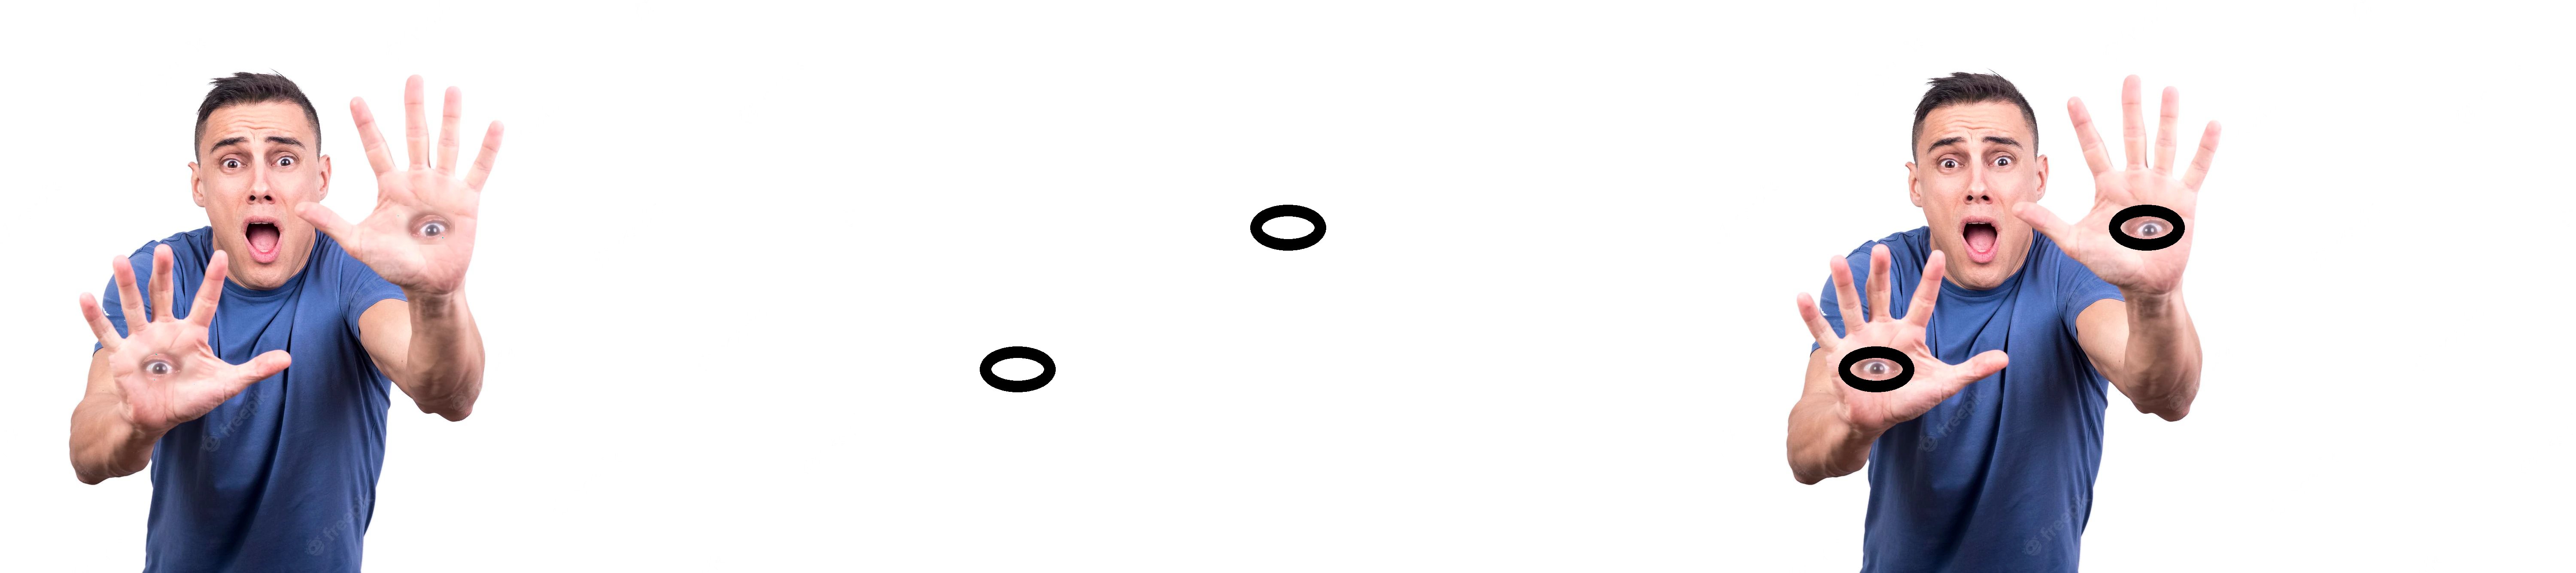

In [ ]:
res = result.copy()
input_mask = cv2.ellipse(
    np.full_like(img, 1.),
    (370, 860), # center
    (75, 40), # axes
    0,
    0,
    360,
    color=(0, 0, 0),
    thickness=25)

input_mask = cv2.ellipse(
    input_mask,
    (1000, 530), # center
    (75, 40), # axes
    0,
    0,
    360,
    color=(0., 0., 0.),
    thickness=25)

tmp = np.hstack([res, input_mask * 255, input_mask * res])
cv2_imshow(tmp)

In [ ]:
res = adopt_image_size(res, 64).transpose(2, 0, 1) / 255
input_mask = adopt_image_size(input_mask, 64).transpose(2, 0, 1) 

In [ ]:
NET_TYPE = "skip_depth6"
PAD = "reflection"
OPT_OVER = "net"
OPTIMIZER = "adam"
INPUT = "noise"

INPUT_DEPTH = 1

NUM_ITER = 3000
LR = 0.01

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [ ]:
depth = int(NET_TYPE[-1])
net = skip(
    INPUT_DEPTH,
    res.shape[0],
    num_channels_down=[16, 32, 64, 128, 128, 128][:depth],
    num_channels_up=[16, 32, 64, 128, 128, 128][:depth],
    num_channels_skip=[0, 0, 0, 0, 0, 0][:depth],
    filter_size_up=3,
    filter_size_down=5,
    filter_skip_size=1,
    upsample_mode='nearest',
    need1x1_up=False,
    need_sigmoid=True,
    need_bias=True,
    pad=PAD,
    act_fun="LeakyReLU"
).to(device)

net_input = get_noise(INPUT_DEPTH, INPUT, res.shape[1:]).to(device)

In [ ]:
mse = torch.nn.MSELoss().to(device)
img_var = np_to_torch(res).to(device)
mask_var = np_to_torch(input_mask.astype('float64')).to(device)

In [ ]:
i = 0
def closure(
    param_noise: bool = True,
    reg_noise_std: float = 0.0,
    plot: bool = True,
    show_every: int = 500,
    figsize: int = 8
):
    global i

    if param_noise:
        for n in [x for x in net.parameters() if len(x.size()) == 4]:
            n = n + n.detach().clone().normal_() * n.std() / 50

    net_input = net_input_saved
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)


    out = net(net_input)

    total_loss = mse(out * mask_var, img_var * mask_var)
    total_loss.backward()

    print('Iteration %05d    Loss %f' % (i, total_loss.item()), '\r', end='')
    if plot and i % show_every == 0:
        out_np = torch_to_np(out)
        plot_image_grid([np.clip(out_np, 0, 1)], factor=figsize, nrow=1)
    i += 1

    return total_loss

In [ ]:
net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()

In [ ]:
p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, NUM_ITER)

Starting optimization with ADAM


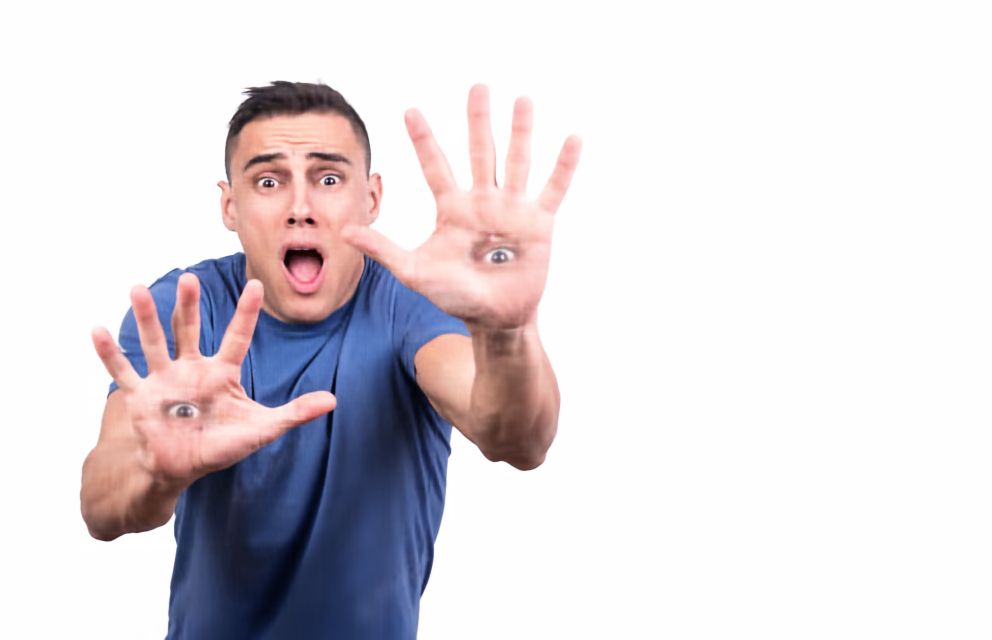

In [ ]:
result = (torch_to_np(net(net_input)) * 255).transpose(1, 2, 0).astype(np.uint8)
result_0 = cv2.resize(result , None, fx=.5, fy=.5)
cv2_imshow(result_0)